<a href="https://colab.research.google.com/github/geomyll33/Beautez/blob/master/anomaly_detection_with_isolation_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [12]:
df=pd.read_csv("/content/ευδαπ_dataset_527085_full.csv")
df.head()

,timestamp,provision_id,meter_id,provision_variation,meter_variation,indication
0,27-05-14,2209151,A09S40233,0-ALLAGI ENOIKOY,0-PROSORINI,0
1,01-01-92,527163,A86P05630,4-KAMIA METABOLI,6-TOPOTHETISI,0
2,27-01-01,527184,A92Z45058,4-KAMIA METABOLI,1-KANONIKI,834
3,11-10-07,2072193,A92Z97030,2-ALLAGI KATASTASI PAROXIS,6-TOPOTHETISI,0
4,15-03-01,1399955,A94E47306,4-KAMIA METABOLI,1-KANONIKI,1292


In [ ]:
metrics_df=pd.pivot_table(df,values='indication',index='timestamp',columns='meter_variation')
metrics_df.reset_index(inplace=True)
metrics_df.fillna(0,inplace=True)
metrics_df

In [4]:
metrics_df.duplicated(keep='last')

0      False
1      False
2      False
3      False
4      False
       ...  
642    False
643    False
644    False
645    False
646    False
Length: 647, dtype: bool

In [14]:
load_date='timestamp'
metric_name='meter_variation'
actuals='indication'

In [15]:
metrics_df.columns
#specify the 12 metrics column names to be modelled
to_model_columns=metrics_df.columns[1:13]
from sklearn.ensemble import IsolationForest
clf=IsolationForest(n_estimators=100, max_samples='auto', contamination=float(.12), \
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42, verbose=0)
clf.fit(metrics_df[to_model_columns])
pred = clf.predict(metrics_df[to_model_columns])
metrics_df['anomaly']=pred
outliers=metrics_df.loc[metrics_df['anomaly']==-1]
outlier_index=list(outliers.index)
#print(outlier_index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(metrics_df['anomaly'].value_counts())

 1    569
-1     78
Name: anomaly, dtype: int64


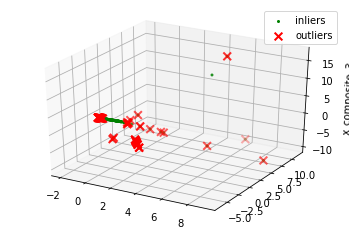

In [7]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
pca = PCA(n_components=3)  # Reduce to k=3 dimensions
scaler = StandardScaler()
#normalize the metrics
X = scaler.fit_transform(metrics_df[to_model_columns])
X_reduce = pca.fit_transform(X)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0],X_reduce[outlier_index,1], X_reduce[outlier_index,2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

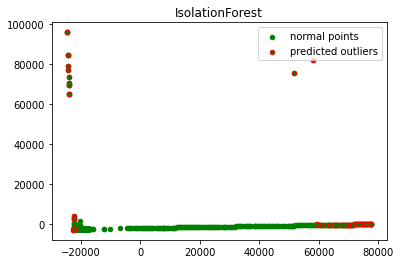

In [16]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(metrics_df[to_model_columns])
res=pd.DataFrame(pca.transform(metrics_df[to_model_columns]))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green',
                 s=20,label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',s=20,  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [4]:
!pip install chart_studio

In [7]:
!pip install plotly
!pip install cufflinks

     |████████████████████████████████| 13.2MB 336kB/s 
  Found existing installation: plotly 2.7.0
    Uninstalling plotly-2.7.0:
      Successfully uninstalled plotly-2.7.0


In [23]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.subplots import make_subplots
import chart_studio.plotly as py
import matplotlib.pyplot as plt
from matplotlib import pyplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [34]:
def plot_anomaly(df,metric_name):
    df.timestamp = pd.to_datetime(df['timestamp'], format ='%d-%m-%y')
    dates = df.timestamp
    #identify the anomaly points and create a array of its values for plot
    bool_array = (abs(df['anomaly']) > 0)
    actuals = df["actuals"][-len(bool_array):]
    anomaly_points = bool_array * actuals
    anomaly_points[anomaly_points == 0] = np.nan
    #A dictionary for conditional format table based on anomaly
    color_map = {0: "'rgba(228, 222, 249, 0.65)'", 1: "yellow", 2: "red"}
    #Table which includes Date,Actuals,Change occured from previous point
    table = go.Table(
        domain=dict(x=[0, 1],
                    y=[0, 0.3]),
        columnwidth=[1, 2],
        # columnorder=[0, 1, 2,],
        header=dict(height=20,
                    values=[['<b>Date</b>'], ['<b>Actual Values </b>'], ['<b>% Change </b>'],
                            ],
                    font=dict(color=['rgb(45, 45, 45)'] * 5, size=14),
                    fill=dict(color='#d562be')),
        cells=dict(values=[df.round(3)[k].tolist() for k in ['timestamp', 'actuals', 'percentage_change']],
                   line=dict(color='#506784'),
                   align=['center'] * 5,
                   font=dict(color=['rgb(40, 40, 40)'] * 5, size=12),
                   # format = [None] + [",.4f"] + [',.4f'],
                   # suffix=[None] * 4,
                   suffix=[None] + [''] + [''] + ['%'] + [''],
                   height=27,
                   fill=dict(color=[test_df['anomaly_class'].map(color_map)],#map based on anomaly level from dictionary
                   )
                   ))
    #Plot the actuals points
    Actuals = go.Scatter(name='Actuals',
                         x=dates,
                         y=df['actuals'],
                         xaxis='x1', yaxis='y1',
                         mode='line',
                         marker=dict(size=12,
                                     line=dict(width=1),
                                     color="blue"))
    
    #Highlight the anomaly points
    anomalies_map = go.Scatter(name="Anomaly",
                               showlegend=True,
                               x=dates,
                               y=anomaly_points,
                               mode='markers',
                               xaxis='x1',
                               yaxis='y1',
                               marker=dict(color="red",
                                           size=11,
                                           line=dict(
                                               color="red",
                                               width=2)))
    axis = dict(
        showline=True,
        zeroline=False,
        showgrid=True,
        mirror=True,
        ticklen=4,
        gridcolor='#ffffff',
        tickfont=dict(size=10))
    
    layout = dict(
        width=1000,
        height=865,
        autosize=False,
        title=metric_name,
        margin=dict(t=75),
        showlegend=True,
        xaxis1=dict(axis, **dict(domain=[0, 1], anchor='y1', showticklabels=True)),
        yaxis1=dict(axis, **dict(domain=[2 * 0.21 + 0.20, 1], anchor='x1', hoverformat='.2f')))
    fig = go.Figure(data=[table, anomalies_map, Actuals], layout=layout)
    iplot(fig)
pyplot.show()


In [37]:
def classify_anomalies(df,metric_name):
    df['metric_name']=metric_name
    df = df.sort_values(by='timestamp', ascending=False)
    #Shift actuals by one timestamp to find the percentage chage between current and previous data point
    df['shift'] = df['actuals'].shift(-1)
    df['percentage_change'] = ((df['actuals'] - df['shift']) / df['actuals']) * 100
    #Categorise anomalies as 0-no anomaly, 1- low anomaly , 2 - high anomaly
    df['anomaly'].loc[df['anomaly'] == 1] = 0
    df['anomaly'].loc[df['anomaly'] == -1] = 2
    df['anomaly_class'] = df['anomaly']
    max_anomaly_score = df['score'].loc[df['anomaly_class'] == 2].max()
    medium_percentile = df['score'].quantile(0.24)
    df['anomaly_class'].loc[(df['score'] > max_anomaly_score) & (df['score'] <= medium_percentile)] = 1
    return df

In [38]:
import warnings  
warnings.filterwarnings('ignore')
for i in range(1,len(metrics_df.columns)-1):
    clf.fit(metrics_df.iloc[:,i:i+1])
    pred = clf.predict(metrics_df.iloc[:,i:i+1])
    test_df=pd.DataFrame()
    test_df['timestamp']=metrics_df['timestamp']
    #Find decision function to find the score and classify anomalies
    test_df['score']=clf.decision_function(metrics_df.iloc[:,i:i+1])
    test_df['actuals']=metrics_df.iloc[:,i:i+1]
    test_df['anomaly']=pred
    #Get the indexes of outliers in order to compare the metrics     with use case anomalies if required
    outliers=test_df.loc[test_df['anomaly']==-1]
    outlier_index=list(outliers.index)
   

In [39]:
test_df=classify_anomalies(test_df,metrics_df.columns[i])
    

In [40]:
plot_anomaly(test_df,metrics_df.columns[i])

ValueError: ignored